**Project: Ride Pricing Prediction**

Predict the price multiplier for a ride,
given demand/supply signals, time, weather, location cluster and traffic. This simulates how Pathao/Ubar like companis might determine dynamic pricing.

**Problem Statement**

- **Goal:** Predict price_multiplier (e.g., 1.0, 1.3) for a ride request so the platform can set dynamic fares.

- **Inputs:** timestamp, area_id, active_drivers_nearby, pending_requests_nearby, distance_km, traffic_level, weather, is_event_day

- **Output:** Continuous multiplier (float)

- **Why it matters:** Improves supply allocation, incentivizes drivers, reduces cancalations.

**Step 1: Create Synthetic data**

This creates realistic demand/supply patters and price multipliers

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta

random.seed(42)

area_count = 30

def generate_data(n=10000, start_date = '2025-01-01'):

  start = datetime.fromisoformat(start_date)
  rows=[]

  for i in range(n):
    ts = start + timedelta(minutes=int(np.random.exponential(60*24)))
    area_id = random.randint(1,area_count)
    distance_km = round(np.random.uniform(0.5,20.0),2)

    active_drivers = np.random.poisson(lam=10) + (2 if area_id % 5 == 0 else 0)
    pending_requests = np.random.poisson(lam=8) + (1 if area_id % 7 == 0 else 0)

    traffic = random.choices(['low','medium','high'], weights=[0.5,0.35,0.15])[0]
    weather = random.choices(['clear','rainy'], weights=[0.8,0.2])[0]

    day_of_week = ts.weekday()
    hour = ts.hour

    is_event = 1 if (area_id % 11 == 0 and random.random() < 0.1) else 0

    demand_supply_ratio = (pending_requests+1)/(active_drivers+1)
    base_multiplier = 1.0+0.5 * max(0, demand_supply_ratio-1)

    # traffic/weather/time effects
    if traffic == 'medium' : base_multiplier +=0.1
    if traffic == 'high' : base_multiplier += 0.3
    if weather == 'rainy' : base_multiplier += 0.15
    if hour in range (7,10) or hour in range (17,20) : base_multiplier +=0.2
    if is_event : base_multiplier += 0.5

    # Adds small random noise
    multiplier = round(min(3.5, base_multiplier + np.random.normal(0,0.1)),2)

    rows.append({
        'timestamp':ts,
        'area_id' : area_id,
        'distance_km' : distance_km,
        'active_drivers' : active_drivers,
        'pending_requests' : pending_requests,
        'traffic' : traffic,
        'weather' : weather,
        'hour' : hour,
        'day_of_week' : day_of_week,
        'is_event' : is_event,
        'price_multiplier' : multiplier
    })

  return pd.DataFrame(rows)

df = generate_data()

In [2]:
df.head()

,timestamp,area_id,distance_km,active_drivers,pending_requests,traffic,weather,hour,day_of_week,is_event,price_multiplier
0,2025-01-01 01:04:00,21,13.99,10,11,low,clear,1,2,0,1.02
1,2025-01-02 00:57:00,8,14.49,7,9,low,clear,0,3,0,1.10
2,2025-01-02 15:59:00,22,3.79,11,8,medium,clear,15,3,0,0.91
3,2025-01-01 17:43:00,2,7.84,12,13,low,clear,17,2,0,1.34
4,2025-01-01 08:27:00,17,16.23,14,11,medium,clear,8,2,0,1.23


**Insight Analysis**

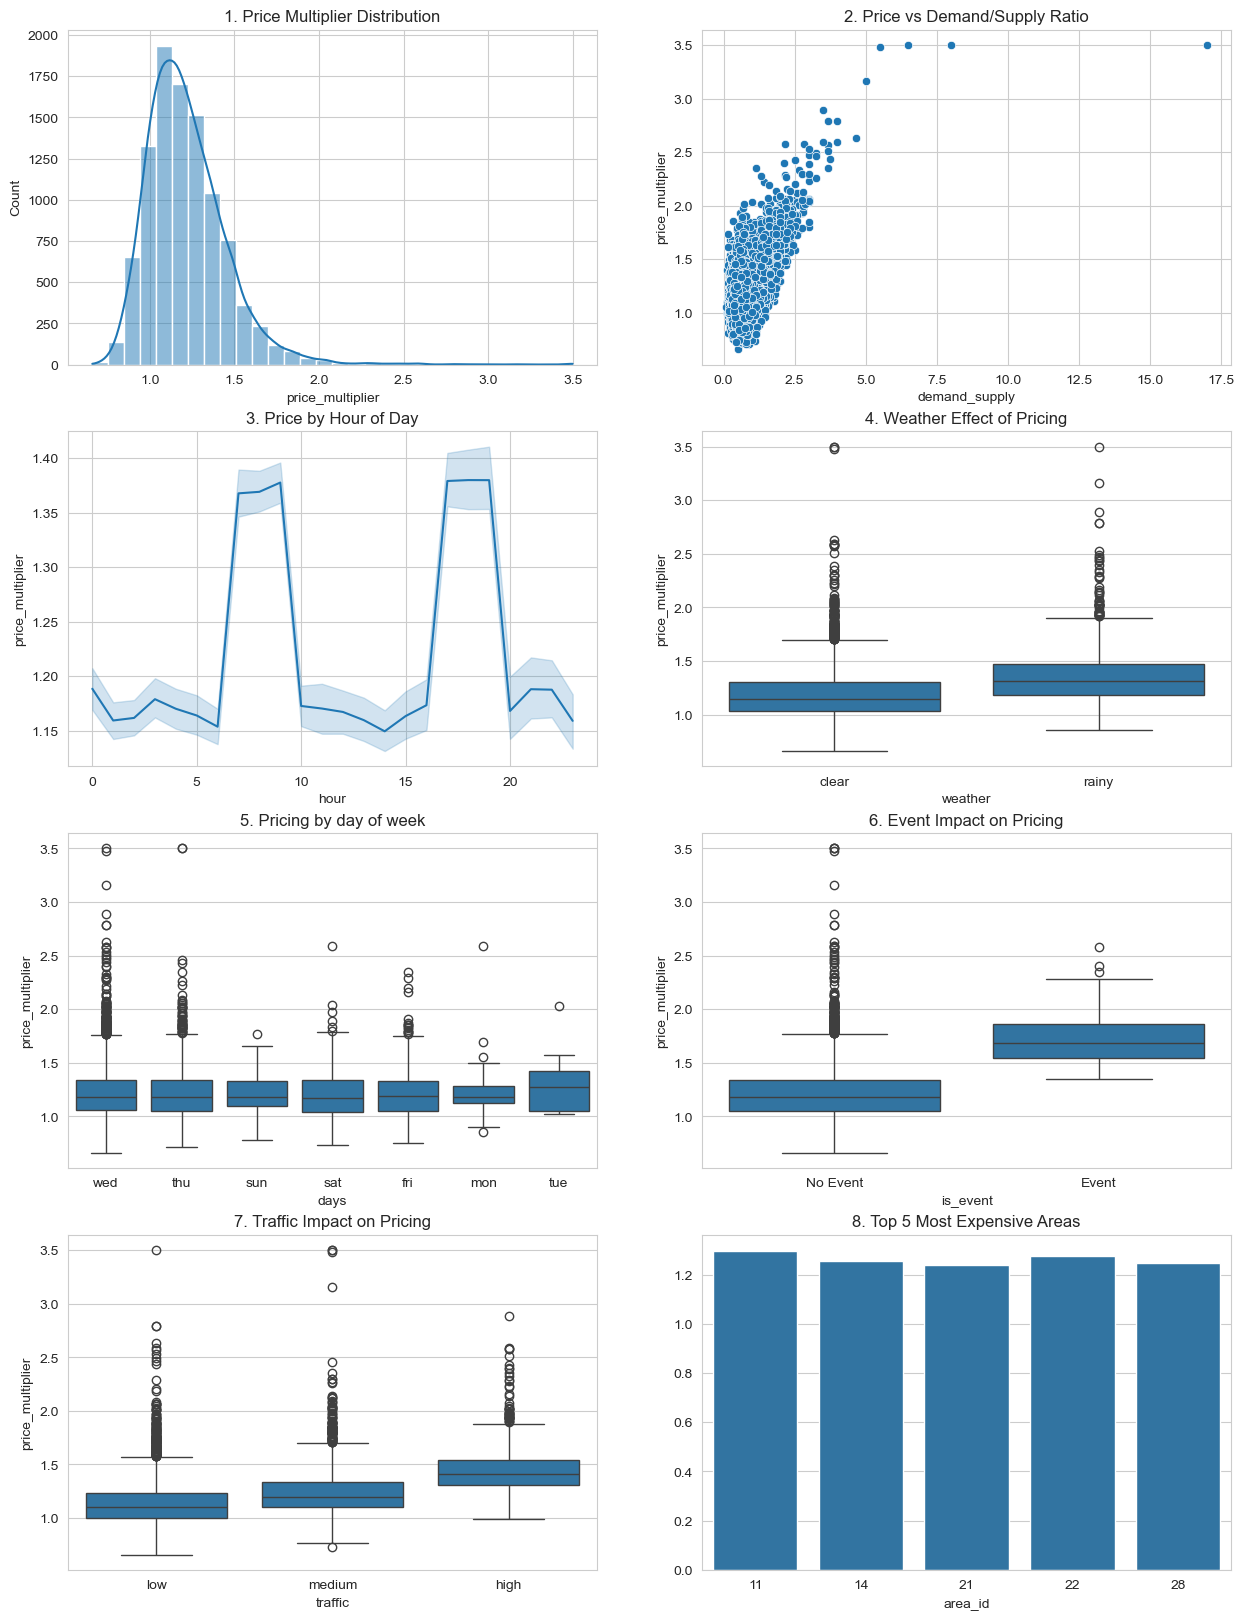

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

new_df = df.copy()

sns.set_style('whitegrid')
plt.figure(figsize=(15,20))

# 1. Price Distribution
plt.subplot(4,2,1)
sns.histplot(new_df['price_multiplier'], bins=30, kde=True)
plt.title('1. Price Multiplier Distribution')

# 2. Demand vs Supply
plt.subplot(4,2,2)
new_df['demand_supply'] = (new_df['pending_requests']+1)/(new_df['active_drivers']+1)
sns.scatterplot(x='demand_supply', y='price_multiplier', data=new_df)
plt.title('2. Price vs Demand/Supply Ratio')

# 3. Hourly Pattern
plt.subplot(4,2,3)
sns.lineplot(x='hour', y='price_multiplier', data=new_df)
plt.title('3. Price by Hour of Day')

# 4. Weather Impact
plt.subplot(4,2,4)
sns.boxplot(x='weather', y='price_multiplier', data=new_df)
plt.title('4. Weather Effect of Pricing')

# 5. Day of Week
plt.subplot(4,2,5)
days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
new_df['days'] = new_df['day_of_week'].map(lambda x: days[x])
sns.boxplot(x='days', y='price_multiplier', data=new_df)
plt.title('5. Pricing by day of week')

# 6. Event Impact
plt.subplot(4,2,6)
sns.boxplot(x='is_event', y='price_multiplier', data=new_df)
plt.title('6. Event Impact on Pricing')
plt.xticks([0,1],['No Event','Event'])

# 7. Traffic Impact
plt.subplot(4,2,7)
sns.boxplot(x='traffic', y='price_multiplier', data=new_df)
plt.title('7. Traffic Impact on Pricing')

# 8. Top Expensive Areas
plt.subplot(4,2,8)
top_areas = new_df.groupby('area_id')['price_multiplier'].mean().nlargest(5)
sns.barplot(x=top_areas.index, y=top_areas.values)
plt.title("8. Top 5 Most Expensive Areas")

plt.show()

**Step 2: Preprocess the data**

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

x = df.drop(columns=['price_multiplier','timestamp'])
y = df['price_multiplier']

categorical = ['traffic', 'weather', 'area_id']
numeric = ['distance_km', 'active_drivers', 'pending_requests', 'hour', 'day_of_week', 'is_event']

# Preprocessor
preprocessor = ColumnTransformer([
  ('cat',OneHotEncoder(handle_unknown='ignore',sparse_output=False),categorical),
  ('num','passthrough',numeric)
])

# Transform x
x_processed = preprocessor.fit_transform(x)

# Get final column names
ohe_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical)
all_columns = list(ohe_names)+numeric

# Convert to DataFrame for readability
x_processed_df = pd.DataFrame(x_processed, columns=all_columns)
x_processed_df.head()

,traffic_high,traffic_low,traffic_medium,weather_clear,weather_rainy,area_id_1,area_id_2,area_id_3,area_id_4,area_id_5,...,area_id_27,area_id_28,area_id_29,area_id_30,distance_km,active_drivers,pending_requests,hour,day_of_week,is_event
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.99,10.0,11.0,1.0,2.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.49,7.0,9.0,0.0,3.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.79,11.0,8.0,15.0,3.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.84,12.0,13.0,17.0,2.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,16.23,14.0,11.0,8.0,2.0,0.0


**Step 3: Train-test split**

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_processed_df, y, test_size=0.33, random_state=42)

**Step 4: Train RandomForestRegressor from Scratch**

In [11]:
from sklearn.tree import DecisionTreeRegressor

class MyRandomForestRegressor:
    def __init__(self, n_estimators=100, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []

        if random_state is not None:
            np.random.seed(random_state)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        self.trees = []

        for i in range(self.n_estimators):
            # Step 1: Bootstrap sample
            X_sample, y_sample = self._bootstrap_sample(X, y)

            # Step 2: Train Decision Tree with max_features per split
            tree = DecisionTreeRegressor(
                max_features=self.max_features,
                random_state=(self.random_state + i) if self.random_state is not None else None,
                min_samples_split=2,
                min_samples_leaf=1,
                max_depth=None
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Step 3: Average predictions from all trees
        all_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(all_preds, axis=0)


# Convert DataFrame to NumPy arrays
x_np = x_train.to_numpy()
y_np = y_train.to_numpy()

# Initialize custom RF
rf = MyRandomForestRegressor(n_estimators=200, max_features=15, random_state=42)
rf.fit(x_np, y_np)

# Predict
preds = rf.predict(x_test.to_numpy())

In [12]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
rmse

0.1212484755855437

Train Built In RandomForestRegressor

In [13]:
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor(n_estimators=500, max_depth=15, random_state=42, n_jobs=-1)
# model.fit(x_train, y_train)

# preds = model.predict(x_test)

# mse = mean_squared_error(y_test, preds)
# rmse = np.sqrt(mse)
# rmse  # [0.11756959416394186]

**Step 5: Save Encoder and Model**

In [14]:
import joblib
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(rf, 'rf_model.pkl', compress=3)

['rf_model.pkl']